In [1]:
from TendersWA import Evaluation as eval
import TendersWA.Preprocessing.Text as text

ModuleNotFoundError: No module named 'TendersWA'

# Loading data and other preparation

In [2]:
# bit of loading data
tenders_structured_path = "../data/UpdatedAgainTenders.xlsx"
import pandas as pd
tenders_structured = pd.read_excel(tenders_structured_path).astype(str)
tenders_structured = tenders_structured[["Reference Number", "Contract Title", "Description", "UNSPSC Title"]].dropna(subset=["Reference Number"]).drop_duplicates(subset = ["Reference Number"])

In [3]:
# clean the descriptions.
for index, row in tenders_structured.iterrows():
    desc = text.remove_html_tags(row["Description"])
    tenders_structured.at[index, "Description"] = desc

In [4]:
import pandas as pd
bert_tender_clusters = pd.read_csv("../data/clustering/bert_clusters.csv", dtype={"Reference Number": str})
bert_cluster_topics = pd.read_csv("../data/clustering/bert_cluster_topics.csv", dtype={"Topics": str})
sentence_bert_tender_clusters = pd.read_csv("../data/clustering/sentence_bert_clusters.csv", dtype={"Reference Number": str})
sentence_bert_cluster_topics = pd.read_csv("../data/clustering/sentence_bert_cluster_topics.csv", dtype={"Topics": str})
summary_tender_clusters = pd.read_csv("../data/clustering/summary_clusters.csv", dtype={"Reference Number": str})
summary_cluster_topics = pd.read_csv("../data/clustering/summary_cluster_topics.csv", dtype={"Topics": str})

In [5]:
# noticed issues with weird stray characters.
def strip_bad_chars(df):
    for index, row in df.iterrows():
        df.at[index, "Reference Number"] = row["Reference Number"].replace("[","").replace("]","")

strip_bad_chars(bert_tender_clusters)
strip_bad_chars(sentence_bert_tender_clusters)
strip_bad_chars(summary_tender_clusters)

In [6]:
import os
import pickle

summary_map = {}
summary_path = "../../data/extended_summaries/"
for ref in list(tenders_structured["Reference Number"]):
    sum_file = os.path.join(summary_path, f"{ref}.pickle.sum")
    if os.path.exists(sum_file):
        loaded_sum = pickle.load(open(sum_file, "rb"))
        summary_map[ref] = loaded_sum

In [7]:
# form unspsc clusters naturally from the titles
unspsc_clusters = {}
unspsc_n = 0
tenders_structured["unspsc_cluster"] = -1
for index, row in tenders_structured.iterrows():
    if row["UNSPSC Title"] not in unspsc_clusters:
        unspsc_clusters[row["UNSPSC Title"]] = unspsc_n
        unspsc_n += 1
    tenders_structured.at[index, "unspsc_cluster"] = unspsc_clusters[row["UNSPSC Title"]]

In [8]:
# manual labels
manual_labelled = pd.read_excel("../data/manual_labels.xlsx", dtype={"Reference Number": str})
manual_labelled = manual_labelled.rename(columns = {"Content": "Description", "Unnamed: 4": "Topics"})
del manual_labelled["Topic"]
del manual_labelled["Processed_Content"]
manual_labelled = manual_labelled.astype(str)

# Generating Evals

## Topic Evaluation generation

In [9]:
def join_df_with_clusters_and_topics(tender_data, tender_clusters, cluster_topics):
    combined = pd.merge(tender_data, tender_clusters, on = "Reference Number", how = "left")
    combined = pd.merge(combined, cluster_topics, on = "Cluster", how = "left")
    return combined

# bert score can take some time, upto 5m
def compute_evals(combined_df, use_summaries = False):
    references = []
    generates = []
    if use_summaries:
        for index, row in combined_df.iterrows():
            ref = row["Reference Number"]
            if ref in summary_map and summary_map[ref]["summary"] != None and summary_map[ref]["summary"] != "":
                references.append(summary_map[ref]["summary"])
            else:
                references.append(row["Description"])
            generates.append(row["Topics"])
        pass
    else:
        references = list(combined_df["Description"])
        generates = list(combined_df["Topics"])
    rogue = eval.eval_rouge(references, generates)
    bert_precision, bert_recall, bert_f1 = eval.eval_bert_score(references, generates)
    return rogue, bert_precision, bert_recall, bert_f1

def compute_unspsc_evals(tender_data):
    references = list(tender_data["Description"])
    generates = list(tender_data["UNSPSC Title"])
    rogue = eval.eval_rouge(references, generates)
    bert_precision, bert_recall, bert_f1 = eval.eval_bert_score(references, generates)
    return rogue, bert_precision, bert_recall, bert_f1

In [10]:
bert_combined = join_df_with_clusters_and_topics(tenders_structured, bert_tender_clusters, bert_cluster_topics)
bert_rogue, bert_precision, bert_recall, bert_f1 = compute_evals(bert_combined)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
sentence_bert_combined = join_df_with_clusters_and_topics(tenders_structured, sentence_bert_tender_clusters, sentence_bert_cluster_topics)
sentence_bert_rogue, sentence_bert_precision, sentence_bert_recall, sentence_bert_f1 = compute_evals(sentence_bert_combined)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
summary_combined = join_df_with_clusters_and_topics(tenders_structured, summary_tender_clusters, summary_cluster_topics)
summary_rogue, summary_precision, summary_recall, summary_f1 = compute_evals(summary_combined, use_summaries = True)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
unspsc_rogue, unspsc_precision, unspsc_recall, unspsc_f1 = compute_unspsc_evals(tenders_structured)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
manual_rogue, manual_precision, manual_recall, manual_f1 = compute_evals(manual_labelled)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Summary Evaluation generation

In [9]:
ref_numbers = []
reference = []
sd_generates = []
summary_generates = []
for key, value in summary_map.items():
    if summary_map[key]["summary"] != None and summary_map[key]["summary"] != "":
        ref_numbers.append(key)
        reference.append(summary_map[key]["relevant"])
        sd_generates.append(summary_map[key]["short_desc"])
        summary_generates.append(summary_map[key]["summary"])

In [10]:
se_summ_rouge = eval.eval_rouge(reference, summary_generates)
se_summ_precision, se_summ_recall, se_summ_f1 = eval.eval_bert_score(reference, summary_generates) 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
se_sd_rouge = eval.eval_rouge(reference, sd_generates)
se_sd_precision, se_sd_recall, se_sd_f1 = eval.eval_bert_score(reference, sd_generates) 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Saving

In [6]:
# will overwrite!
def save_evals(fname, rouge, bs_precision, bs_recall, bs_f1):
    pickle.dump({"rouge": rouge, "bs_precision": bs_precision, "bs_recall": bs_recall, "bs_f1": bs_f1}, open(fname, "wb"))

In [7]:
save_evals("summary_eval_summaries.cached.pickle", se_summ_rouge, se_summ_precision, se_summ_recall, se_summ_f1)
save_evals("summary_eval_short_desc.cached.pickle", se_sd_rouge, se_sd_precision, se_sd_recall, se_sd_f1)

NameError: name 'se_summ_rouge' is not defined

In [19]:
save_evals("topic_eval_bert.cached.pickle", bert_rogue, bert_precision, bert_recall, bert_f1)
save_evals("topic_eval_sentence_bert.cached.pickle", sentence_bert_rogue, sentence_bert_precision, sentence_bert_recall, sentence_bert_f1)
save_evals("topic_eval_summary.cached.pickle", summary_rogue, summary_precision, summary_recall, summary_f1)
save_evals("topic_eval_unspsc.cached.pickle", unspsc_rogue, unspsc_precision, unspsc_recall, unspsc_f1)
save_evals("topic_eval_manual.cached.pickle", manual_rogue, manual_precision, manual_recall, manual_f1)

# Cached 

In [1]:
import pickle
def load_evals(fname):
    return pickle.load(open(fname, "rb"))

In [2]:
summary_eval_summaries = load_evals("summary_eval_summaries.cached.pickle")
summary_eval_short_desc = load_evals("summary_eval_short_desc.cached.pickle")

In [3]:
topic_eval_bert = load_evals("topic_eval_bert.cached.pickle")
topic_eval_sentence_bert = load_evals("topic_eval_sentence_bert.cached.pickle")
topic_eval_summary = load_evals("topic_eval_summary.cached.pickle")
topic_eval_unspsc = load_evals("topic_eval_unspsc.cached.pickle")
topic_eval_manual = load_evals("topic_eval_manual.cached.pickle")

# Charts

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:

# Averaging ROUGE metrics
avg_rouge = {
    key: {
        metric: np.mean([eval[key][metric] for eval in summary_eval_short_desc['rouge']])
        for metric in ['p', 'r', 'f']
    } 
    for key in ['rouge-1', 'rouge-2', 'rouge-l']
}

# Averaging BERTScore metrics
avg_bertscore = {
    metric: np.mean(summary_eval_short_desc[metric].numpy())
    for metric in ['bs_precision', 'bs_recall', 'bs_f1']
}



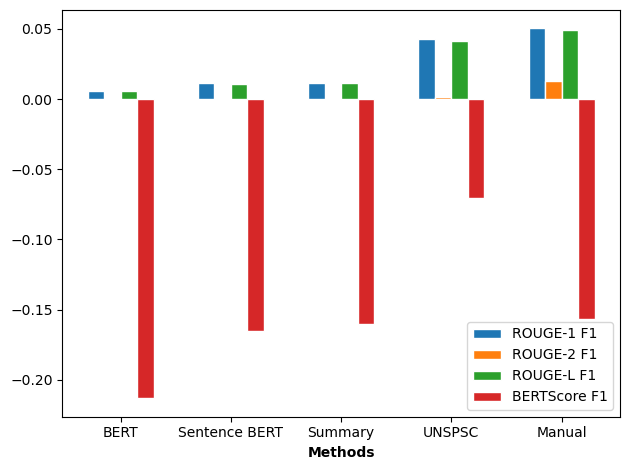

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def extract_average_metrics(data):
    """Extracts average metrics from the provided data."""
    avg_rouge1_f1 = np.mean([entry['rouge-1']['f'] for entry in data['rouge']])
    avg_rouge2_f1 = np.mean([entry['rouge-2']['f'] for entry in data['rouge']])
    avg_rougel_f1 = np.mean([entry['rouge-l']['f'] for entry in data['rouge']])
    avg_bs_f1 = np.mean(data['bs_f1'].numpy())  # Assuming you have PyTorch
    
    return avg_rouge1_f1, avg_rouge2_f1, avg_rougel_f1, avg_bs_f1

# Extract average metrics for each method
bert_metrics = extract_average_metrics(topic_eval_bert)
sentence_bert_metrics = extract_average_metrics(topic_eval_sentence_bert)
summary_metrics = extract_average_metrics(topic_eval_summary)
unspsc_metrics = extract_average_metrics(topic_eval_unspsc)
manual_metrics = extract_average_metrics(topic_eval_manual)

# Data to plot
n_methods = 5
f1_scores = [bert_metrics, sentence_bert_metrics, summary_metrics, unspsc_metrics, manual_metrics]

# Create a bar plot
barWidth = 0.15
r1 = np.arange(n_methods)
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]
r4 = [x + 3*barWidth for x in r1]

plt.bar(r1, [score[0] for score in f1_scores], width=barWidth, edgecolor='white', label='ROUGE-1 F1')
plt.bar(r2, [score[1] for score in f1_scores], width=barWidth, edgecolor='white', label='ROUGE-2 F1')
plt.bar(r3, [score[2] for score in f1_scores], width=barWidth, edgecolor='white', label='ROUGE-L F1')
plt.bar(r4, [score[3] for score in f1_scores], width=barWidth, edgecolor='white', label='BERTScore F1')

# Add labels
methods = ['BERT', 'Sentence BERT', 'Summary', 'UNSPSC', 'Manual']
plt.xlabel('Methods', fontweight='bold')
plt.xticks([r + 1.5*barWidth for r in range(n_methods)], methods)  # Adjusted tick positioning
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
